# $I_{local}$ for 1D tuning 

author: laquitainesteeve@gmail.com from code by Matthew Chalk

## Setup 

setup fisher_info_limits2

In [782]:
# import packages
import os
import numpy as np
from numpy import log, zeros, exp, sqrt, pi
from numpy.random import rand, randn, poisson
import matplotlib.pyplot as plt
from scipy.special import gammaln

# setup project path
proj_path = '/home/steeve/steeve/idv/code/fisher-info-limits'
os.chdir(proj_path)

# setup pipeline parameters
SEED = 0
nxplot = 50
dx = 0.01            # smaller dx = slower but more accurate

# setup tuning curve parameters
sigmaf = np.pi / 4   # tuning curve width
f0 = 5               # baseline firing rate
A = 20               # amplitude
n_neurons = 4        # Number of neurons

## Functions

In [783]:
# utils
def sum2(data, axis=1): 
    """sum over columns (axis 1)
    while keeping data dimensionality

    Args:
        data (_type_): _description_
        axis (int, optional): _description_. Defaults to 1.

    Returns:
        _type_: _description_
    """
    return data.sum(axis, keepdims=True)


def wrap_to_pi(dirs: np.array):
    """wrap circularly

    Args:
        dirs (np.array): directions in radians

    Returns:
        np.array: directions wrapped circularly
    """
    return ((dirs + pi) % (2 * pi) - pi).flatten()


# -------------------------------

def tuning_curve(x):
    """Wrapped Gaussian tuning curve function
    
    Args:
        x (np.array): scalar or array of angles of shape (1, N)
    
    Returns: 
        array of shape (n_neurons, len(x)) firing rates
    """
    x = np.atleast_1d(x).flatten()
    
    # compute wrapped distance
    dx = np.arctan2(np.sin(x[:, None] - mu[None, :]), np.cos(x[:, None] - mu[None, :]))
    
    # Gaussian response
    return (f0 + A * np.exp(-0.5 * (dx**2) / sigmaf**2)).T


def tuning_curve_grad(dirs: np.array):
    """Gradient of the tuning curve (derivative)
    
    Args:
        dirs (np.array): scalar or array of angles of shape (1, N)
    
    Returns: 
        (np.array): shape (n_neurons, len(directions)) gradients
    """
    dirs = np.atleast_1d(dirs).flatten()
    dx = np.arctan2(np.sin(dirs[:, None] - mu[None, :]), np.cos(dirs[:, None] - mu[None, :]))
    return (-A * dx * np.exp(-0.5 * dx**2 / sigmaf**2) / sigmaf**2).T


def logsumexp(a, axis=0):
    """
    Computes log(sum(exp(a), axis)) while avoiding numerical underflow.
    Equivalent to MATLAB's logsumexp by Tom Minka.

    Parameters
    ----------
    a : np.ndarray
        Input array.
    axis : int, optional
        Axis along which to sum. Default is 0.

    Returns
    -------
    s : np.ndarray
        Log-sum-exp of the input along the specified axis.
    """
    # find the maximum along the specified axis (for numerical stability)
    a_max = np.max(a, axis=axis, keepdims=True)

    # subtract and exponentiate
    a_stable = a - a_max
    s = a_max + log(np.sum(np.exp(a_stable), axis=axis, keepdims=True))

    # remove the extra dimension
    s = np.squeeze(s, axis=axis)
    a_max = np.squeeze(a_max, axis=axis)

    # handle non-finite max values (like -inf)
    return np.where(np.isfinite(a_max), s, a_max)


# unit-testing  ----------------------------------

def test_logpr_x0():
    """test logpr_x0 function
    """
    # mock inputs
    xsamp_rates = np.array([5.9539, 22.9341, 11.1758, 5.0390])[None].T
    r = np.array([[ 6], [26], [10], [ 1]])
    
    # compute logpr_x0
    logpr_x0 =  log(xsamp_rates.T) @ r - sum2(xsamp_rates.T) - sum(gammaln(r + 1))
    assert np.allclose(logpr_x0, -10.1409248, atol=1e-3), "wrong logpr_x0"


def test_logpr_x():
    """test logpr_x function
    """
    # mock inputs
    x = np.array([[-3.1416 , -3.1316]])
    r = np.array([[ 6], [26], [10], [ 1]])
    x_rates = tuning_curve(x)
    
    # compute logpr_x
    logpr_x =  log(x_rates.T) @ r - sum2(x_rates.T) - sum(gammaln(r + 1)) # OK!
    assert np.allclose(logpr_x, np.array([[-48.25999692], [-48.18853962]]), atol=1e-6), "test_logpr_x() failed"


def test_logsumexp():
    # mock inputs
    logpr_x = np.array([[-48.25999692], [-48.18853962]])

    # compte lse
    lse = logsumexp(logpr_x, 0)
    assert np.allclose(lse, np.array([[-47.53048296]]), atol=1e-6), "logsumexp failed"


def test_tuning_curve_grad():
    """test tuning curve gradient function
    """
    # mockup inputs (directions)
    dirs =  np.array([[-3.14159265e+00, -3.01592895e+00, -2.89026524e+00, -2.76460154e+00]])
    
    # compute gradients
    grads = tuning_curve_grad(dirs)

    # test
    assert np.allclose(grads, np.array([
        [15.4452, 15.0314, 13.7417, 11.5672],
        [0.8487, 1.2818, 1.8812, 2.6814],
        [-0.8487, -0.5461, -0.3417, -0.2079],
        [-15.4452, -15.0732, -14.0655, -12.6056]
    ]), atol=1e-4), "tuning_curve_grad failed"


def test_fisher_info():

    # mock inputs
    dirs = np.array([[-3.14159265, -3.01592895, -2.89026524, -2.76460154]])

    # compute fisher
    J = (tuning_curve_grad(dirs).T**2./tuning_curve(dirs).T).sum(1)

    # test
    assert np.allclose(J, np.array([28.1270, 27.1648, 24.5063, 20.7885]), atol=1e-6), "fisher_info() failed"


def test_wrap_to_pi():

    # mock inputs
    dirs = np.array([[-3.14159265e+00, -3.01592895e+00, -2.89026524e+00, -2.76460154e+00,
       -2.63893783e+00, -2.51327412e+00, -2.38761042e+00, -2.26194671e+00,
       -2.13628300e+00, -2.01061930e+00, -1.88495559e+00, -1.75929189e+00,
       -1.63362818e+00, -1.50796447e+00, -1.38230077e+00, -1.25663706e+00,
       -1.13097336e+00, -1.00530965e+00, -8.79645943e-01, -7.53982237e-01,
       -6.28318531e-01, -5.02654825e-01, -3.76991118e-01, -2.51327412e-01,
       -1.25663706e-01,  4.44089210e-16,  1.25663706e-01,  2.51327412e-01,
        3.76991118e-01,  5.02654825e-01,  6.28318531e-01,  7.53982237e-01,
        8.79645943e-01,  1.00530965e+00,  1.13097336e+00,  1.25663706e+00,
        1.38230077e+00,  1.50796447e+00,  1.63362818e+00,  1.75929189e+00,
        1.88495559e+00,  2.01061930e+00,  2.13628300e+00,  2.26194671e+00,
        2.38761042e+00,  2.51327412e+00,  2.63893783e+00,  2.76460154e+00,
        2.89026524e+00,  3.01592895e+00]])
    
    rnd = np.array([
        -0.6081, -0.4396, 0.7560, -0.5936, 1.2913, 1.2006, -1.1463, 2.4775, 0.8119, -1.1888,
        0.5800, -0.1021, 0.8390, 1.4902, 1.8763, -0.4803, 0.4383, 0.7523, -0.6582, 0.1953,
        -0.5800, 0.8231, 1.6579, -1.1299, 0.3225, 1.4268, -0.5214, 1.9585, 1.1557, 0.2722,
        -1.3106, 0.8983, 0.6447, -0.2131, 1.6926, -0.8838, 1.0818, -0.0759, -0.2023, 0.0525,
        1.1412, 1.4822, -0.7172, -0.1546, -0.0839, 3.2410, 1.8107, -1.0137, 0.5381, 0.8643
    ])

    gamma = 0.3998253360767657

    # compute output
    output = wrap_to_pi(dirs + sqrt(gamma).T * rnd)

    # test
    assert np.allclose(output, np.array([
        2.7571,  2.9893, -2.4123, -3.1400, -1.8224, -1.7541, -3.1124, -0.6954, -1.6229, -2.7623,
        -1.5182, -1.8238, -1.1031, -0.5657, -0.1959, -1.5603, -0.8538, -0.5296, -1.2959, -0.6305,
        -0.9950,  0.0178,  0.6713, -0.9658,  0.0783,  0.9022, -0.2040,  1.4897,  1.1078,  0.6748,
        -0.2004,  1.3220,  1.2873,  0.8706,  2.2012,  0.6978,  2.0663,  1.4600,  1.5057,  1.7925,
        2.6065,  2.9479,  1.6828,  2.1642,  2.3345, -1.7206, -2.4993,  2.1237, -3.0527, -2.7207
    ]), atol=1e-4), "wrap_to_pi() failed"

## Tests

In [784]:
# run unit-tests
test_logpr_x0()
test_logpr_x()
test_logsumexp()
test_tuning_curve_grad()
test_fisher_info()
test_wrap_to_pi()

## Neural encoder

In [785]:
# x points to plot, from -pi to pi
xplot = np.linspace(-pi, pi, nxplot + 1)
xplot = xplot[:-1]                              # OK!

# x used to compute probability distributions
# of shape (1, N)
x = np.arange(-pi, pi, dx)
x = x[:-1][None]                                       # OK!

Text(0.5, 1.0, 'Neural Tuning Curves')

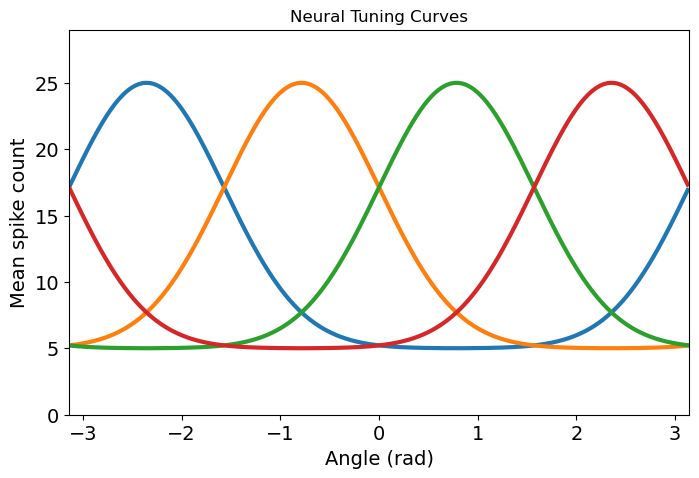

In [786]:
# position centers of tuning curves, uniformly spaced
mu = np.linspace(-pi, pi, n_neurons + 1)[:-1]
mu = mu - np.mean(mu)

# plot tuning curves
plt.figure(figsize=(8, 5))
plt.plot(x.flatten(), tuning_curve(x).T, linewidth=3)
plt.ylabel('Mean spike count', fontsize=14)
plt.xlabel('Angle (rad)', fontsize=14)
plt.xlim([-pi, pi])
plt.ylim([0, f0 + 1.2*A])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Neural Tuning Curves')

In [ ]:
%%time 

np.random.seed(SEED)

# compute information, Inf = I(R;X) - brute force calculation
# required:

# Initialize variables
Inf = 0              # I(R;X)
nsamp = int(1e4)     # number of samples

# report
print("\nComputing I(R;X), brute force")

# average neural response to x
x_rates = tuning_curve(x) # OK!

for i in range(nsamp):

    # sample stimulus uniformly between -pi and pi 
    # a scalar   
    xsamp = rand() * 2 * pi - pi  # OK!

    # sample response from Poisson with rate f(xsamp)
    # r is of shape (n_neurons,1)
    xsamp_rates = tuning_curve(xsamp)     # OK!
    r = poisson(xsamp_rates)      # OK!
    
    # log p(rsamp|xsamp), a scalar
    logpr_x0 = log(xsamp_rates.T) @ r - sum2(xsamp_rates.T) - sum(gammaln(r + 1)) # OK!

    # estimate log p(rsamp)
    logpr_x = log(x_rates.T) @ r - sum2(x_rates.T) - sum(gammaln(r + 1)) # OK!

    # log(p(r))
    logpr = logsumexp(logpr_x,0) - log(len(x)) # OK!

    # mutual information (~1.87)
    Inf = Inf * (i)/(i + 1) + (logpr_x0 - logpr)/(i + 1) # OK!


Computing I(R;X), brute force
CPU times: user 540 ms, sys: 878 μs, total: 541 ms
Wall time: 540 ms


## Compute Ilocal

In [ ]:
%%time 

# limits of gamma to sample. Smaller gamma_min more accurate only if dx is
# very small (so slower). 
gamma_min = 0.1
gamma_max = 50
nsamp = 10000  # number of samples     # OK!

# Initialise I_local(x) = mean( I_i(x) ), where mean is over samples
Ilocal = zeros((1,nxplot))

# Initialise mean( I_i(x).^2 ), where mean is over samples, useful for err bars
Ilocal2 = zeros((1,nxplot)) # OK!

# Fisher information
J = (tuning_curve_grad(xplot).T**2./tuning_curve(xplot).T).sum(1) # OK!

# Compute integral between gamma=0 and gamma=gamma_min analytically
I0 = log(1 + gamma_min * J) / 2         # OK!

print("\nComputing I_local(x)")

# average neural response to x
x_rates = tuning_curve(x) # OK!

# index for wrapped gaussian
k = np.arange(-20,21).reshape(1,1,-1)

for i in range(nsamp):

    # sample gamma from p(gamma)~1/gamma, between gamma_min and gamma_mas
    gamma = exp( rand() * (log(gamma_max) - log(gamma_min)) + log(gamma_min)) # OK!

    # sample y~p(y|x), of shape (len(x), )
    y = wrap_to_pi(xplot + sqrt(gamma).T * randn(1,nxplot)) # OK!

    # sample r~p(r|y), of shape (n_neurons, len(x))
    r = poisson( tuning_curve(wrap_to_pi(y + sqrt(gamma).T * randn(1,nxplot))) )

    # compute log p(r|x)
    logpr_x =  log(x_rates.T) @ r - sum2(x_rates.T) - sum(gammaln(r+1)) # OK!

    # compute d p(y|x)/dy, where p(y|x) is wrapped gaussian, of shape (len(x), nxplot)
    dphi = (((x.T-y)[:,:,None] + 2*pi*k) / gamma * exp(-0.5*((x.T-y)[:,:,None] + 2*pi*k)**2 / gamma ) / sqrt(2*pi*gamma)).sum(2) # OK!

    # compute d p(r|y)/dy, of shape (nxplot,)
    dpr_y = sum(exp(logpr_x) * dphi, 0) * dx

    # compute log p(y|x), where p(y|x) is wrapped gaussian
    logphi = logsumexp(-0.5*((x.T-y)[:,:,None] + 2*pi*k)**2 / gamma - 0.5*log(2*pi*gamma),2); # OK!

    # compute p(r|y)
    logpr_y = logsumexp(logphi + logpr_x + log(dx), 0)

    # combine, to compute dlogp(r|y) = dp(r|y)/p(r|y)
    dlogpr_y = dpr_y  / exp(logpr_y)

    # update for Ilocal
    dIlocal = 0.5 * log(gamma_max / gamma_min) * gamma * dlogpr_y**2 + I0

    # update Ilocal
    Ilocal = Ilocal*(i)/(i+1) + dIlocal/(i+1)

    # update term for error
    Ilocal2 = Ilocal2*(i)/(i+1) + dIlocal**2/(i+1)

# compute metrics
Ilocal_err = sqrt(Ilocal2 - Ilocal**2) / sqrt(nsamp)
Inf_aprx = np.mean(Ilocal)
Inf_err = sqrt(np.mean(Ilocal_err**2))


Computing I_local(x)
CPU times: user 3min 29s, sys: 2.94 s, total: 3min 32s
Wall time: 3min 28s


## Plot

In [762]:
Ilocal2

array([[11.62149043, 10.72919943, 10.84307296, 10.43707324, 10.9138845 ,
         9.96062392, 10.67245219, 10.95098056, 10.99293229,  9.97063255,
        10.01224016, 10.69114855, 10.95158183, 10.97524564, 11.04328389,
        11.13699651, 10.31145352, 10.39835535, 10.48724517,  9.95059522,
        10.13074491, 10.9663651 , 11.20717683, 10.82920669, 11.4208131 ,
        11.67326559, 11.29497274, 11.17113169, 10.46235374, 10.3707154 ,
         9.84647709, 10.22198528,  9.88770527, 10.32841893, 10.53444651,
        11.2090494 , 10.78569899, 11.36520872, 10.83476118, 11.61799088,
        10.46884036, 10.45956358, 10.50524395,  9.22087416, 10.55677081,
        10.97241917, 10.42499102, 11.18924376, 10.73554722, 10.86183331]])

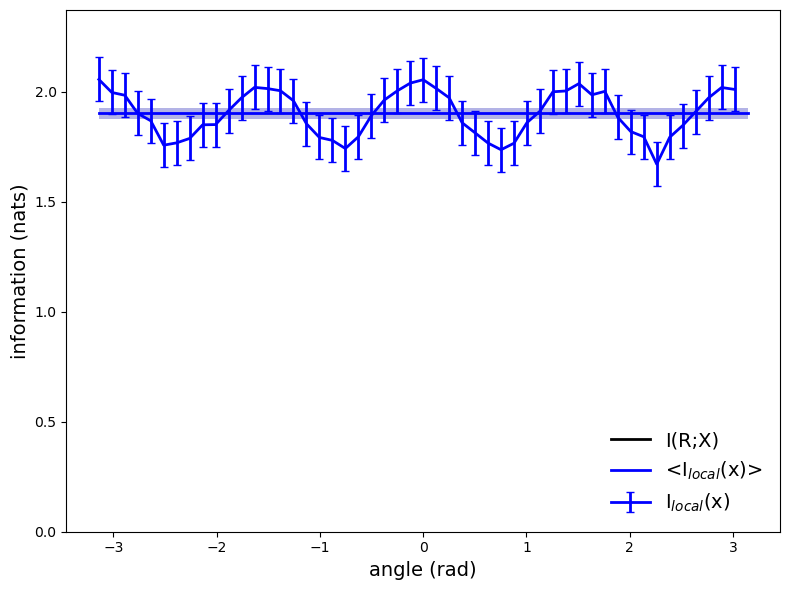

In [789]:
# Create figure
fig, ax = plt.subplots(figsize=(8, 6))

# Fill area for confidence interval
ax.fill_between([-np.pi, np.pi], 
                 Inf_aprx - Inf_err, 
                 Inf_aprx + Inf_err, 
                 color=[0.7, 0.7, 0.9], 
                 edgecolor='none', 
                 label='')

# error bar plot
ax.errorbar(xplot, Ilocal.flatten(), yerr=std_err, color='b', linewidth=2, 
            label='I$_{local}$(x)', capsize=3)

# Horizontal line at Inf
ax.plot([-np.pi, np.pi], [Inf.flatten(), Inf.flatten()], 'k', linewidth=2, label='I(R;X)')

# Horizontal line at Inf_aprx
ax.plot([-np.pi, np.pi], [Inf_aprx, Inf_aprx], 'b', linewidth=2, 
        label='<I$_{local}$(x)>')

# Labels and formatting
ax.set_ylabel('information (nats)', fontsize=14)
ax.set_xlabel('angle (rad)', fontsize=14)
ax.set_ylim([0, 1.1 * np.max(Ilocal + std_err)])

# Legend
ax.legend(fontsize=14, frameon=False, loc='lower right')

plt.tight_layout()
plt.show()